In [ ]:
!pip install sklearn-crfsuite

In [ ]:
!pip install eli5

In [ ]:
#Data analysis
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
import eli5

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


**Load data**

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/GMB_dataset.txt", sep="\t", header=None, encoding="latin1")

In [ ]:
data.head(30)

,0,1,2,3,4
0,NaN,Sentence #,Word,POS,Tag
1,0.0,1.0,Thousands,NNS,O
2,1.0,1.0,of,IN,O
3,2.0,1.0,demonstrators,NNS,O
4,3.0,1.0,have,VBP,O
5,4.0,1.0,marched,VBN,O
6,5.0,1.0,through,IN,O
7,6.0,1.0,London,NNP,B-geo
8,7.0,1.0,to,TO,O
9,8.0,1.0,protest,VB,O


As you can see the first row of the dataframe looks like header. I am removing the column index and replacing it with column header.

In [ ]:
data.columns = data.iloc[0]
data = data[1:]
data.columns = ['Index','Sentence #','Word','POS','Tag']
data = data.reset_index(drop=True)
data.tail(20)

,Index,Sentence #,Word,POS,Tag
66141,66141.0,2998.0,for,IN,O
66142,66142.0,2998.0,an,DT,O
66143,66143.0,2998.0,attempted,JJ,O
66144,66144.0,2998.0,assassination,NN,O
66145,66145.0,2998.0,of,IN,O
66146,66146.0,2998.0,Saddam,NNP,B-per
66147,66147.0,2998.0,.,.,O
66148,66148.0,2999.0,The,DT,O
66149,66149.0,2999.0,judge,NN,O
66150,66150.0,2999.0,told,VBD,O


In [ ]:
data.shape

(66161, 5)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66161 entries, 0 to 66160
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Index       66161 non-null  float64
 1   Sentence #  66161 non-null  object 
 2   Word        66161 non-null  object 
 3   POS         66161 non-null  object 
 4   Tag         66161 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.5+ MB


In [ ]:
# A class to retrieve the sentences from the dataset
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = getsentence(data)
sentences = getter.sentences
#This is how a sentence will look like. 
print(sentences[:2])

[[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')], [('Iranian', 'JJ', 'B-gpe'), ('officials', 'NNS', 'O'), ('say', 'VBP', 'O'), ('they', 'PRP', 'O'), ('expect', 'VBP', 'O'), ('to', 'TO', 'O'), ('get', 'VB', 'O'), ('access', 'NN', 'O'), ('to', 'TO', 'O'), ('sealed', 'JJ', 'O'), ('sensitive', 'JJ', 'O'), ('parts', 'NNS', 'O'), ('of', 'IN', 'O'), ('the', 'DT', 'O'), ('plant', 'NN', 'O'), ('Wednesday', 'NNP', 'B-tim'), (',', ',', 'O'), ('after', 'IN', 'O'), ('an', 'DT', 'O'), ('IAEA', 'NNP', 'B-org'

In [ ]:
#Lets find the number of unique words in the dataset
words = list(set(data["Word"].values))
n_words = len(words)
print(n_words)

8766


In [ ]:
for s in sentences[:2]:
  print(s)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]
[('Iranian', 'JJ', 'B-gpe'), ('officials', 'NNS', 'O'), ('say', 'VBP', 'O'), ('they', 'PRP', 'O'), ('expect', 'VBP', 'O'), ('to', 'TO', 'O'), ('get', 'VB', 'O'), ('access', 'NN', 'O'), ('to', 'TO', 'O'), ('sealed', 'JJ', 'O'), ('sensitive', 'JJ', 'O'), ('parts', 'NNS', 'O'), ('of', 'IN', 'O'), ('the', 'DT', 'O'), ('plant', 'NN', 'O'), ('Wednesday', 'NNP', 'B-tim'), (',', ',', 'O'), ('after', 'IN', 'O'), ('an', 'DT', 'O'), ('IAEA', 'NNP', 'B-org'),

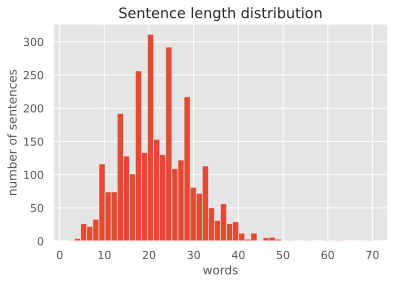

In [ ]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Sentence length distribution')
#plt.show()
plt.xlabel("words")
plt.ylabel("number of sentences")
plt.savefig('/content/sample_data/data_distribution.png')

In [ ]:
#Lets find out the longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 70


In [ ]:
#Words tagged as B-org
data.loc[data['Tag'] == 'B-org', 'Word'].head()

97             Labor
154    International
215             IAEA
234         European
248             U.N.
Name: Word, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


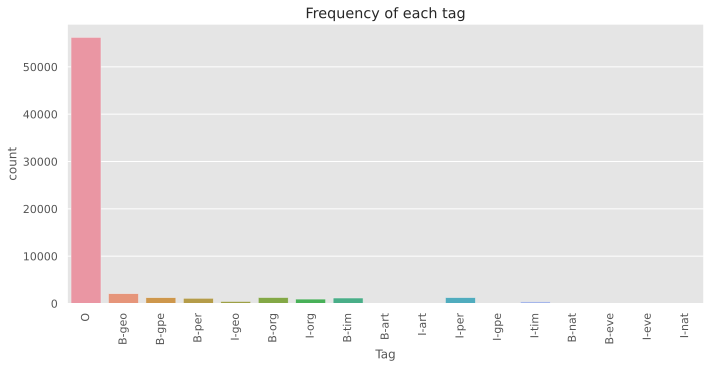

In [ ]:
#Words distribution across Tags
plt.figure(figsize=(10, 5))
ax = sns.countplot('Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.title("Frequency of each tag")
#plt.show()
plt.savefig("word_class_distribution.png")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


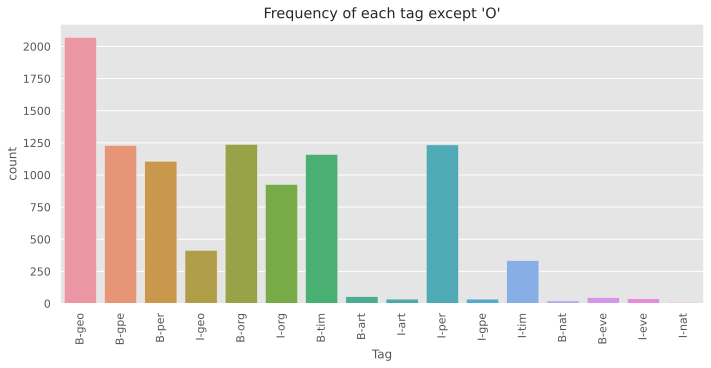

In [ ]:
#Words distribution across Tags without O tag
plt.figure(figsize=(10, 5))
ax = sns.countplot('Tag', data=data.loc[data['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.title("Frequency of each tag except 'O'")
#plt.show()
plt.savefig("word_distri.png")

dataset mostly contains words related to geographical locations, geopolitical entities and person names.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


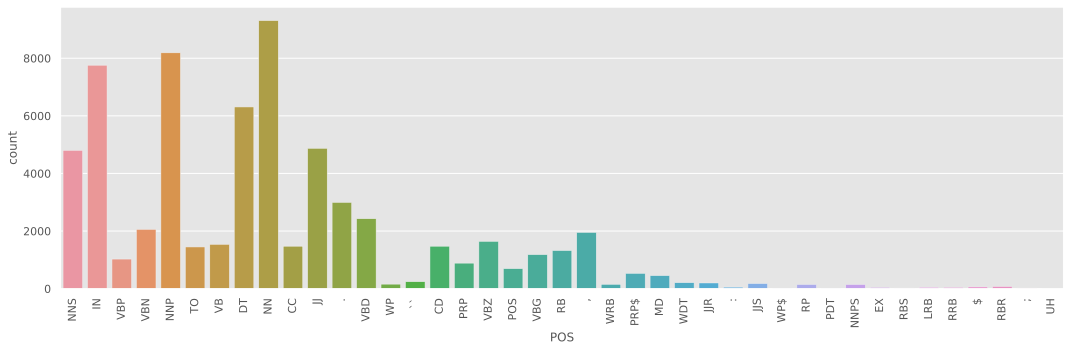

In [ ]:
#Words distribution across POS
plt.figure(figsize=(15, 5))
ax = sns.countplot('POS', data=data, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
#plt.show()
plt.savefig("word_distribution_pos.png")

In [ ]:
data['Tag'].value_counts()

O        56217
B-geo     2070
B-org     1237
I-per     1234
B-gpe     1230
B-tim     1160
B-per     1107
I-org      926
I-geo      414
I-tim      334
B-art       53
B-eve       45
I-eve       37
I-gpe       34
I-art       34
B-nat       20
I-nat        9
Name: Tag, dtype: int64

Random Forest Classifier

In [ ]:
#Simple feature map to feed arrays into the classifier. 
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

In [ ]:
words = [feature_map(w) for w in data["Word"].values.tolist()]
tags = data["Tag"].values.tolist()

In [ ]:
print(words[:5])

[array([1, 0, 0, 9, 0, 1]), array([0, 1, 0, 2, 0, 1]), array([ 0,  1,  0, 13,  0,  1]), array([0, 1, 0, 4, 0, 1]), array([0, 1, 0, 7, 0, 1])]


In [ ]:
tags[:9]

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X,y=words,tags

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
set(y_test)

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}

In [ ]:
len(X_train)

52928

In [ ]:
len(X_test)

13233

Not using cross fold

In [ ]:
no_cv_rf = RandomForestClassifier(n_estimators=500, random_state=12)
no_cv_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [ ]:
pred_no_cv=no_cv_rf.predict(X_test)

In [ ]:
len(y_test)

13233

In [ ]:
#Lets check the performance 
from sklearn.metrics import classification_report
report_no_cv = classification_report(y_pred=pred_no_cv, y_true=y_test)
print(report_no_cv)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        14
       B-eve       0.00      0.00      0.00         8
       B-geo       0.22      0.78      0.35       385
       B-gpe       0.24      0.06      0.10       241
       B-nat       0.00      0.00      0.00         7
       B-org       0.62      0.15      0.24       232
       B-per       1.00      0.14      0.25       207
       B-tim       0.26      0.32      0.29       229
       I-art       0.00      0.00      0.00         5
       I-eve       0.00      0.00      0.00         3
       I-geo       0.00      0.00      0.00        76
       I-gpe       0.00      0.00      0.00         8
       I-nat       0.00      0.00      0.00         4
       I-org       0.35      0.04      0.07       185
       I-per       0.44      0.02      0.03       253
       I-tim       0.57      0.06      0.10        71
           O       0.97      0.98      0.98     11305

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
labels = list(no_cv_rf.classes_)

labels

['B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O']

In [ ]:
labels.remove('O')

In [ ]:
labels

['B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim']

In [ ]:
print(classification_report(y_pred=pred_no_cv, y_true=y_test,labels=labels))

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        14
       B-eve       0.00      0.00      0.00         8
       B-geo       0.22      0.78      0.35       385
       B-gpe       0.24      0.06      0.10       241
       B-nat       0.00      0.00      0.00         7
       B-org       0.62      0.15      0.24       232
       B-per       1.00      0.14      0.25       207
       B-tim       0.26      0.32      0.29       229
       I-art       0.00      0.00      0.00         5
       I-eve       0.00      0.00      0.00         3
       I-geo       0.00      0.00      0.00        76
       I-gpe       0.00      0.00      0.00         8
       I-nat       0.00      0.00      0.00         4
       I-org       0.35      0.04      0.07       185
       I-per       0.44      0.02      0.03       253
       I-tim       0.57      0.06      0.10        71

   micro avg       0.26      0.24      0.25      1928
   macro avg       0.23   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


using cross fold

In [ ]:
#Random Forest classifier
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words, y=tags, cv=5)

In [ ]:
#Lets check the performance 
from sklearn.metrics import classification_report
report = classification_report(y_pred=pred, y_true=tags)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        53
       B-eve       0.00      0.00      0.00        45
       B-geo       0.23      0.72      0.35      2070
       B-gpe       0.16      0.12      0.14      1230
       B-nat       0.00      0.00      0.00        20
       B-org       0.63      0.16      0.25      1237
       B-per       0.97      0.19      0.31      1107
       B-tim       0.28      0.33      0.31      1160
       I-art       0.00      0.00      0.00        34
       I-eve       0.00      0.00      0.00        37
       I-geo       0.00      0.00      0.00       414
       I-gpe       0.00      0.00      0.00        34
       I-nat       0.00      0.00      0.00         9
       I-org       0.33      0.03      0.05       926
       I-per       0.37      0.01      0.02      1234
       I-tim       0.47      0.05      0.09       334
           O       0.97      0.98      0.98     56217

    accuracy              

Remove class O

In [ ]:
data_without_o=data.loc[data['Tag'] != 'O']

In [ ]:
data.head()

,Index,Sentence #,Word,POS,Tag
0,0.0,1.0,Thousands,NNS,O
1,1.0,1.0,of,IN,O
2,2.0,1.0,demonstrators,NNS,O
3,3.0,1.0,have,VBP,O
4,4.0,1.0,marched,VBN,O


In [ ]:
data_without_o.head()

,Index,Sentence #,Word,POS,Tag
6,6.0,1.0,London,NNP,B-geo
12,12.0,1.0,Iraq,NNP,B-geo
18,18.0,1.0,British,JJ,B-gpe
42,42.0,2.0,Bush,NNP,B-per
65,65.0,3.0,Hyde,NNP,B-geo


In [ ]:
words_new = [feature_map(w) for w in data_without_o["Word"].values.tolist()]
tags_new = data_without_o["Tag"].values.tolist()

In [ ]:
print(words_new[:5])

[array([1, 0, 0, 6, 0, 1]), array([1, 0, 0, 4, 0, 1]), array([1, 0, 0, 7, 0, 1]), array([1, 0, 0, 4, 0, 1]), array([1, 0, 0, 4, 0, 1])]


In [ ]:
X,y=words_new,tags_new

In [ ]:
X_train_O, X_test_O, y_train_O, y_test_O = train_test_split(X, y, test_size=0.2)

Not using cross fold

In [ ]:
O_cv_rf = RandomForestClassifier(n_estimators=500, random_state=12)
O_cv_rf.fit(X_train_O, y_train_O)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [ ]:
pred_O=O_cv_rf.predict(X_test_O)

In [ ]:
len(y_test)

13233

In [ ]:
#Lets check the performance 
from sklearn.metrics import classification_report
report_O = classification_report(y_pred=pred_O, y_true=y_test_O)
print(report_O)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         9
       B-eve       0.00      0.00      0.00         7
       B-geo       0.28      0.63      0.39       424
       B-gpe       0.24      0.34      0.28       241
       B-nat       0.00      0.00      0.00         4
       B-org       0.49      0.25      0.33       237
       B-per       0.42      0.31      0.36       216
       B-tim       0.40      0.46      0.43       261
       I-art       0.00      0.00      0.00         6
       I-eve       0.00      0.00      0.00         6
       I-geo       0.00      0.00      0.00        78
       I-gpe       0.00      0.00      0.00         5
       I-nat       0.00      0.00      0.00         2
       I-org       0.33      0.04      0.07       189
       I-per       0.44      0.02      0.03       240
       I-tim       0.52      0.50      0.51        64

    accuracy                           0.32      1989
   macro avg       0.19   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Using cross fold

In [ ]:
#Random Forest classifier
pred_new = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words_new, y=tags_new, cv=5)

Accuracy dropped significantly - using cross fold

In [ ]:
#Lets check the performance 
from sklearn.metrics import classification_report
report_new = classification_report(y_pred=pred_new, y_true=tags_new)
print(report_new)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        53
       B-eve       0.00      0.00      0.00        45
       B-geo       0.26      0.72      0.38      2070
       B-gpe       0.20      0.14      0.16      1230
       B-nat       0.00      0.00      0.00        20
       B-org       0.55      0.22      0.31      1237
       B-per       0.42      0.33      0.37      1107
       B-tim       0.35      0.42      0.38      1160
       I-art       0.00      0.00      0.00        34
       I-eve       0.67      0.05      0.10        37
       I-geo       0.00      0.00      0.00       414
       I-gpe       0.00      0.00      0.00        34
       I-nat       0.00      0.00      0.00         9
       I-org       0.33      0.06      0.10       926
       I-per       0.51      0.03      0.05      1234
       I-tim       0.52      0.49      0.51       334

    accuracy                           0.31      9944
   macro avg       0.24   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Over sampling the minority data

In [ ]:
# example of evaluating a decision tree with random oversampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#Simple feature map to feed arrays into the classifier. 
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

In [ ]:
words = [feature_map(w) for w in data["Word"].values.tolist()]
tags = data["Tag"].values.tolist()

In [ ]:
X,y=words,tags

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# example of oversampling a multi-class classification dataset
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [ ]:
len(X_train)

52928

In [ ]:
# transform the dataset
oversample = SMOTE()
X_train_sme, y_train_sme = oversample.fit_resample(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
# summarize distribution
counter = Counter(y_train_sme)

In [ ]:
counter

Counter({'B-art': 44960,
         'B-eve': 44960,
         'B-geo': 44960,
         'B-gpe': 44960,
         'B-nat': 44960,
         'B-org': 44960,
         'B-per': 44960,
         'B-tim': 44960,
         'I-art': 44960,
         'I-eve': 44960,
         'I-geo': 44960,
         'I-gpe': 44960,
         'I-nat': 44960,
         'I-org': 44960,
         'I-per': 44960,
         'I-tim': 44960,
         'O': 44960})

In [ ]:
# summarize distribution
counter_test = Counter(y_test)
counter_test

Counter({'B-art': 13,
         'B-eve': 11,
         'B-geo': 398,
         'B-gpe': 241,
         'B-nat': 3,
         'B-org': 227,
         'B-per': 228,
         'B-tim': 231,
         'I-art': 6,
         'I-eve': 9,
         'I-geo': 86,
         'I-gpe': 7,
         'I-nat': 2,
         'I-org': 184,
         'I-per': 265,
         'I-tim': 65,
         'O': 11257})

Class=O, n=44960 (67.955%)
Class=I-org, n=44960 (67.955%)
Class=B-tim, n=44960 (67.955%)
Class=B-org, n=44960 (67.955%)
Class=I-per, n=44960 (67.955%)
Class=I-tim, n=44960 (67.955%)
Class=B-gpe, n=44960 (67.955%)
Class=B-geo, n=44960 (67.955%)
Class=B-per, n=44960 (67.955%)
Class=I-geo, n=44960 (67.955%)
Class=I-art, n=44960 (67.955%)
Class=I-eve, n=44960 (67.955%)
Class=I-gpe, n=44960 (67.955%)
Class=B-art, n=44960 (67.955%)
Class=I-nat, n=44960 (67.955%)
Class=B-eve, n=44960 (67.955%)
Class=B-nat, n=44960 (67.955%)


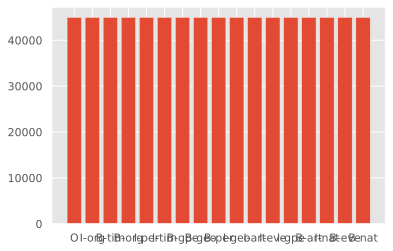

In [ ]:
for k,v in counter.items():
  per = v / len(y) * 100
  print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
clf_rf_sme = RandomForestClassifier(n_estimators=500, random_state=12)
clf_rf_sme.fit(X_train_sme, y_train_sme)
#clf_rf.score(X_test, y_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [ ]:
pred_sme=clf_rf_sme.predict(X_test)

In [ ]:
len(y_test)

13233

In [ ]:
#Lets check the performance 
from sklearn.metrics import classification_report
report = classification_report(y_pred=pred_sme, y_true=y_test)
print(report)

              precision    recall  f1-score   support

       B-art       0.07      0.08      0.07        13
       B-eve       0.01      0.18      0.02        11
       B-geo       0.14      0.00      0.00       398
       B-gpe       0.30      0.07      0.11       241
       B-nat       0.01      0.33      0.02         3
       B-org       0.24      0.06      0.10       227
       B-per       0.93      0.19      0.31       228
       B-tim       0.16      0.16      0.16       231
       I-art       0.00      0.00      0.00         6
       I-eve       0.01      0.44      0.01         9
       I-geo       0.00      0.00      0.00        86
       I-gpe       0.01      0.43      0.02         7
       I-nat       0.00      0.50      0.01         2
       I-org       0.16      0.07      0.10       184
       I-per       0.00      0.00      0.00       265
       I-tim       0.03      0.51      0.06        65
           O       0.99      0.86      0.92     11257

    accuracy              

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, clf_rf.predict(X_test),average='weighted')

0.7471472833068843

Finished Random forest classification

Conditional Random Fields classifier

In [ ]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [ ]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [ ]:
sentences[:1]

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')]]

In [ ]:
len(X_train)

52928

In [ ]:
#Creating the train and test set
from sklearn.model_selection import train_test_split 
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
len(X_train)

2399

In [ ]:
len(X_test)

600

In [ ]:
len(X)

2999

In [ ]:
sentences[:1]

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')]]

In [ ]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [ ]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)


CPU times: user 38 µs, sys: 3 µs, total: 41 µs
Wall time: 46 µs


using 5 fold

In [ ]:
#We predcit using the same 5 fold cross validation
y_pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
report = flat_classification_report(y_pred, y)
print(report)

              precision    recall  f1-score   support

       B-art       0.02      0.17      0.03         6
       B-eve       0.27      0.52      0.35        23
       B-geo       0.83      0.72      0.77      2392
       B-gpe       0.75      0.85      0.79      1085
       B-nat       0.20      0.50      0.29         8
       B-org       0.59      0.67      0.63      1086
       B-per       0.78      0.79      0.79      1084
       B-tim       0.82      0.89      0.85      1061
       I-art       0.00      0.00      0.00         4
       I-eve       0.22      0.53      0.31        15
       I-geo       0.62      0.67      0.64       383
       I-gpe       0.09      0.25      0.13        12
       I-nat       0.33      1.00      0.50         3
       I-org       0.71      0.71      0.71       935
       I-per       0.91      0.82      0.86      1369
       I-tim       0.57      0.75      0.65       255
           O       0.99      0.99      0.99     56440

    accuracy              

below 2 lines of codes are without 5 fold

In [ ]:
X_train[:1]

[[{'+1:postag': 'NN',
   '+1:postag[:2]': 'NN',
   '+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:word.lower()': 'spokesman',
   'BOS': True,
   'bias': 1.0,
   'postag': 'DT',
   'postag[:2]': 'DT',
   'word.isdigit()': False,
   'word.istitle()': True,
   'word.isupper()': True,
   'word.lower()': 'a',
   'word[-2:]': 'A',
   'word[-3:]': 'A'},
  {'+1:postag': 'IN',
   '+1:postag[:2]': 'IN',
   '+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:word.lower()': 'for',
   '-1:postag': 'DT',
   '-1:postag[:2]': 'DT',
   '-1:word.istitle()': True,
   '-1:word.isupper()': True,
   '-1:word.lower()': 'a',
   'bias': 1.0,
   'postag': 'NN',
   'postag[:2]': 'NN',
   'word.isdigit()': False,
   'word.istitle()': False,
   'word.isupper()': False,
   'word.lower()': 'spokesman',
   'word[-2:]': 'an',
   'word[-3:]': 'man'},
  {'+1:postag': 'NNP',
   '+1:postag[:2]': 'NN',
   '+1:word.istitle()': True,
   '+1:word.isupper()': False,
   '+1:word.lower()': 'gazpr

In [ ]:
y_train[:3]

[['O',
  'O',
  'O',
  'B-org',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'B-gpe',
  'B-per',
  'I-per',
  'I-per',
  'I-per',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-gpe',
  'O'],
 ['B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [ ]:
crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [ ]:
len(X_train)

2399

In [ ]:
len(X_test)

600

In [ ]:
len(y_test)

600

In [ ]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted')

0.9530950093137586

In [ ]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
sorted_labels

['O',
 'B-art',
 'I-art',
 'B-eve',
 'I-eve',
 'B-geo',
 'I-geo',
 'B-gpe',
 'I-gpe',
 'B-nat',
 'I-nat',
 'B-org',
 'I-org',
 'B-per',
 'I-per',
 'B-tim',
 'I-tim']

In [ ]:
print(flat_classification_report(
    y_test, y_pred,labels=sorted_labels
))

              precision    recall  f1-score   support

           O       0.99      0.99      0.99     11612
       B-art       0.40      0.25      0.31         8
       I-art       0.00      0.00      0.00         3
       B-eve       0.25      0.20      0.22         5
       I-eve       0.50      0.17      0.25         6
       B-geo       0.69      0.84      0.76       414
       I-geo       0.62      0.52      0.56        81
       B-gpe       0.82      0.77      0.79       258
       I-gpe       0.67      0.33      0.44         6
       B-nat       1.00      0.14      0.25         7
       I-nat       1.00      0.20      0.33         5
       B-org       0.70      0.54      0.61       281
       I-org       0.71      0.64      0.67       204
       B-per       0.76      0.80      0.78       236
       I-per       0.78      0.89      0.83       267
       B-tim       0.90      0.84      0.87       240
       I-tim       0.83      0.66      0.74        86

    accuracy              

lets remove class O

In [ ]:
labels = list(crf.classes_)

In [ ]:
labels

['O',
 'B-org',
 'B-gpe',
 'B-per',
 'I-per',
 'B-tim',
 'B-geo',
 'I-org',
 'I-tim',
 'I-geo',
 'B-eve',
 'I-eve',
 'B-art',
 'I-gpe',
 'I-art',
 'B-nat',
 'I-nat']

In [ ]:

labels.remove('O')
labels

['B-org',
 'B-gpe',
 'B-per',
 'I-per',
 'B-tim',
 'B-geo',
 'I-org',
 'I-tim',
 'I-geo',
 'B-eve',
 'I-eve',
 'B-art',
 'I-gpe',
 'I-art',
 'B-nat',
 'I-nat']

In [ ]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.7408070530263096

After removing class O , the f1_score still shows good value

In [ ]:
# group B and I results

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

print(flat_classification_report(
    y_test, y_pred,labels=sorted_labels
))

              precision    recall  f1-score   support

       B-art       0.40      0.25      0.31         8
       I-art       0.00      0.00      0.00         3
       B-eve       0.25      0.20      0.22         5
       I-eve       0.50      0.17      0.25         6
       B-geo       0.69      0.84      0.76       414
       I-geo       0.62      0.52      0.56        81
       B-gpe       0.82      0.77      0.79       258
       I-gpe       0.67      0.33      0.44         6
       B-nat       1.00      0.14      0.25         7
       I-nat       1.00      0.20      0.33         5
       B-org       0.70      0.54      0.61       281
       I-org       0.71      0.64      0.67       204
       B-per       0.76      0.80      0.78       236
       I-per       0.78      0.89      0.83       267
       B-tim       0.90      0.84      0.87       240
       I-tim       0.83      0.66      0.74        86

   micro avg       0.75      0.74      0.75      2107
   macro avg       0.66   

In [ ]:
#Now we will create the Randomized CV search model wherein we will use a modified F1 scorer model considering only the relevant labels
# define fixed parameters and parameters to search
crf3 = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 36.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=0.1, c2=0.1,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_te...
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f38ab953d50>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighted, l

In [ ]:
print('Best parameters:', rs.best_params_)
print('Best CV score:', rs.best_score_)
print('Model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

Best parameters: {'c1': 0.17226611510504447, 'c2': 0.1279980509113799}
Best CV score: 0.7452733049285082
Model size: 0.61M


In [ ]:
#Now we create the model again using the best estimators
crf3 = rs.best_estimator_
y_pred = crf3.predict(X)
print(metrics.flat_classification_report(
    y, y_pred, digits=3))

              precision    recall  f1-score   support

       B-art      0.962     0.962     0.962        53
       B-eve      0.978     0.978     0.978        45
       B-geo      0.887     0.966     0.925      2070
       B-gpe      0.953     0.880     0.915      1230
       B-nat      1.000     0.850     0.919        20
       B-org      0.958     0.857     0.905      1237
       B-per      0.970     0.967     0.969      1107
       B-tim      0.987     0.934     0.960      1160
       I-art      1.000     1.000     1.000        34
       I-eve      1.000     0.946     0.972        37
       I-geo      0.905     0.944     0.924       414
       I-gpe      0.938     0.441     0.600        34
       I-nat      1.000     1.000     1.000         9
       I-org      0.976     0.971     0.973       926
       I-per      0.964     0.991     0.977      1234
       I-tim      0.981     0.949     0.965       334
           O      0.997     0.999     0.998     56217

    accuracy              

In [ ]:
#Now we create the model again using the best estimators
crf3 = rs.best_estimator_
y_pred = crf3.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3))

              precision    recall  f1-score   support

       B-per      0.967     0.970     0.968       364
       I-per      0.954     1.000     0.977       396
       B-tim      0.995     0.934     0.963       408
       B-org      0.970     0.842     0.902       419
       I-org      0.984     0.965     0.974       310
       I-tim      0.984     0.945     0.964       127
       B-geo      0.872     0.973     0.919       657
       I-geo      0.906     0.940     0.923       133
       B-eve      1.000     1.000     1.000        13
       B-nat      1.000     0.857     0.923         7
       B-gpe      0.947     0.864     0.904       412
       I-eve      1.000     1.000     1.000        12
       B-art      0.857     0.857     0.857        14
       I-art      1.000     1.000     1.000         4
       I-gpe      1.000     0.400     0.571        10
       I-nat      1.000     1.000     1.000         5

   micro avg      0.945     0.935     0.940      3291
   macro avg      0.965   

Hyperparameter Optimization

To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

In [ ]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 24.5min finished


CPU times: user 14min 20s, sys: 5.06 s, total: 14min 25s
Wall time: 24min 40s


Best results

In [ ]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.1432245186912512, 'c2': 0.21751659219899847}
best CV score: 0.7564454317001839
model size: 0.52M


Dark blue => 0.7267, dark red => 0.7564


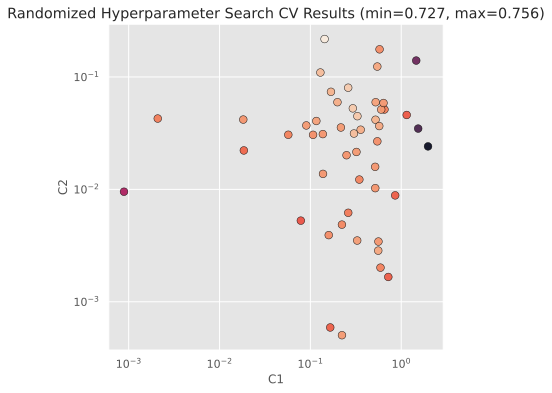

In [ ]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(6,6)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [ ]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-art      0.250     0.071     0.111        14
       I-art      0.000     0.000     0.000         4
       B-eve      0.429     0.231     0.300        13
       I-eve      0.750     0.250     0.375        12
       B-geo      0.706     0.860     0.776       657
       I-geo      0.673     0.541     0.600       133
       B-gpe      0.844     0.777     0.809       412
       I-gpe      1.000     0.200     0.333        10
       B-nat      1.000     0.143     0.250         7
       I-nat      1.000     0.200     0.333         5
       B-org      0.728     0.537     0.618       419
       I-org      0.735     0.645     0.687       310
       B-per      0.784     0.816     0.799       364
       I-per      0.759     0.932     0.837       396
       B-tim      0.925     0.814     0.866       408
       I-tim      0.843     0.591     0.694       127

   micro avg      0.770     0.749     0.760      3291
   macro avg      0.714   

In [ ]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-geo  -> I-geo   5.682330
B-tim  -> I-tim   5.437136
B-org  -> I-org   5.314368
B-per  -> I-per   4.978456
I-org  -> I-org   4.973689
I-tim  -> I-tim   4.936380
I-per  -> I-per   4.891806
B-art  -> I-art   4.760881
I-art  -> I-art   4.305233
I-geo  -> I-geo   4.233342
B-eve  -> I-eve   4.155746
B-gpe  -> I-gpe   3.678515
O      -> O       3.535741
I-gpe  -> I-gpe   3.384389
I-eve  -> I-eve   3.036805
B-nat  -> I-nat   2.489609
O      -> B-per   1.692267
B-geo  -> B-tim   1.602308
O      -> B-tim   1.439387
O      -> B-org   1.423159

Top unlikely transitions:
O      -> I-eve   -0.978880
B-geo  -> I-org   -0.980901
B-org  -> I-per   -0.981992
B-gpe  -> I-org   -1.007779
B-geo  -> I-gpe   -1.019925
B-geo  -> I-per   -1.087746
B-tim  -> B-tim   -1.135647
B-org  -> B-org   -1.141812
I-org  -> I-per   -1.177864
B-geo  -> B-org   -1.254548
O      -> I-art   -1.443963
B-geo  -> B-per   -1.697911
B-tim  -> B-gpe   -1.900895
I-per  -> B-per   -2.016075
O      -> I-per  